In [1]:
import os
import shutil
from pathlib import Path
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

from timescales.autoreg.fit import ARPSD

from eigvec.circulant import compute_kappa
from eigvec.spectral import compute_eigenspectrum

## Circulant Covariance and Allen Data

This notebook shows as the number of rows (e.g. trials and channels) increase, the covariance matrix becomes increasingly circulant. First, LFP data from the Allen Instituted is loaded. The next two cells take a long time to run. This notebook requires ~16gb free memory, less may run into errors.

In [2]:
# Paths
output_dir = '../data/ecephys_cache_dir'

manifest_path = os.path.join(output_dir, "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

sessions = cache.get_session_table()

# First mouse
session = cache.get_session_data(
    sessions.index.values[0],
    isi_violations_maximum = np.inf,
    amplitude_cutoff_maximum = np.inf,
    presence_ratio_minimum = -np.inf
)

# Load LFP on first probe
probe_id = session.probes[session.probes.description == 'probeA'].index.values[0]
lfp = session.get_lfp(probe_id)

# Get trial names, ignore "spontaneous" because of too little data
trial_names = np.unique(session.stimulus_presentations.stimulus_name.values)
trial_names = [i for i in trial_names if i not in ['spontaneous', 'flashes']]

In [3]:
# {session.probes.loc[probe_id].description : 
#      list(session.channels[session.channels.probe_id == probe_id].ecephys_structure_acronym.unique())
#      for probe_id in session.probes.index.values}

In [6]:
# Choose stimuli
selected_stimuli = [
    "drifting_gratings",
    "gabors",
    "natural_movie_one"
]

# Results for each trial
fs = 500
X = []
regions = []
powers = np.zeros((len(selected_stimuli), 250))
kappas = np.zeros(len(selected_stimuli))
covx = np.zeros((len(selected_stimuli), 500, 500))

# For each trial type, compute kappa
for it, tname in enumerate(trial_names):

    if tname not in selected_stimuli:
        continue
        
    print(tname)
    
    # Epoch data around events
    presentation_table = session.stimulus_presentations[
        session.stimulus_presentations.stimulus_name == tname
    ]

    presentation_times = presentation_table.start_time.values
    presentation_ids = presentation_table.index.values
    
    trial_window = np.arange(0, 1., 1/fs)
    time_selection = np.concatenate([trial_window + t for t in presentation_times])
    
    inds = pd.MultiIndex.from_product((presentation_ids, trial_window), 
                                      names=('presentation_id', 'time_from_presentation_onset'))
    
    ds = lfp.sel(time=time_selection, method='nearest').to_dataset(name='aligned_lfp')
    ds = ds.assign(time=inds).unstack('time')

    # Get LFP: (channel, trial, time)
    x = ds['aligned_lfp']
    del ds
    
    # Take channel in visual cortex
    regions = []
    
    for i in x.channel.to_numpy():
        regions.append(
            session.channels.iloc[
                session.channels.index == i
            ]["ecephys_structure_acronym"].iloc[0]
        )
    
    region_inds = np.where(np.array(regions) == "VISam")[0]
    
    x = x[region_inds, :5_000].to_numpy()
    print(x.shape)
    x = x.reshape(-1, 500)
    
    # Drop nan rows
    not_nan = ~np.isnan(x.sum(axis=1))
    not_nan.sum()
    x = x[not_nan]

    # Normalize
    x = (x - x.mean()) / x.std()
    X.append(x)
    
    # Compute covariance
    cov = np.cov(x.T)
    covx[it] = cov
    
    # Kappa
    kappas[it] = compute_kappa(cov, method='eig')

    # Eigenspectrum
    freqs, p = compute_eigenspectrum(cov, fs)
    powers[it] = p

powers = np.stack(powers)

drifting_gratings
(21, 628, 500)
gabors
(21, 3645, 500)
natural_movie_one
(21, 5000, 500)


In [223]:
# Flip order so natural movie is first. I want that on top
#   of the plots
X = X[::-1]
powers = powers[::-1]
kappas = kappas[::-1]
covx = covx[::-1]

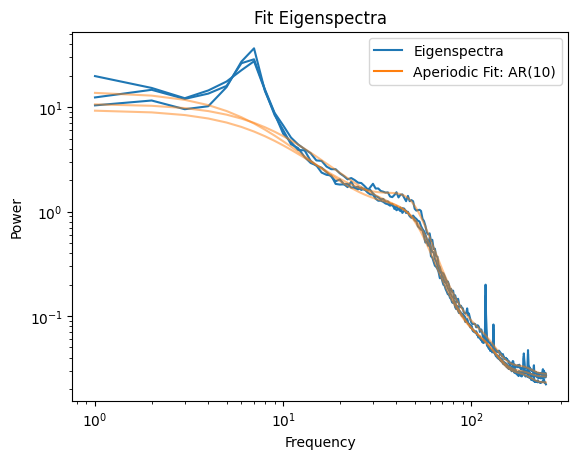

In [224]:
# Frequency weights
sigma = 10**np.exp(-np.abs(freqs - 7)**2 / (2* (3**2)))
sigma += 0.000001

kwargs = {'sigma':sigma}

# Init model and array
psd = ARPSD(10, fs, ar_bounds=(-100, 100), maxfev=10000, 
            loss_fn='cauchy', f_scale=0.25, curve_fit_kwargs=kwargs)

powers_fit = np.zeros_like(powers)

# Fit
for i in range(len(powers)):
    psd.fit(freqs, powers[i], )
    powers_fit[i] = psd.powers_fit

# Plot
for p in powers:
    plt.loglog(freqs[1:], p[1:], color='C0')
    #break
    
for p in powers_fit:
    plt.loglog(freqs[1:],p[1:], color='C1', alpha=0.5)

plt.title('Fit Eigenspectra')
plt.loglog([], [], color='C0', label='Eigenspectra')
plt.loglog([], [], color='C1', label='Aperiodic Fit: AR(10)')
plt.ylabel("Power")
plt.xlabel("Frequency")
plt.legend();

In [225]:
def invert_eig(X, vals, vecs):
    """Invert eigendecomposition back to the time domain."""
    
    # SVD
    S = np.diag(np.sqrt(np.diag(vals)))
    V = vecs
    
    # Left singular vectors
    U = X @ V
    for i in range(U.shape[1]):
        U[:, i] = U[:, i] / np.linalg.norm(U[:, i])

    # Reconstruct signals
    X_re = (U @ S @ V.conj().T).real
    X_re = X_re * np.sqrt(len(X))

    return X_re

def update_vals(cov, vals_fit):
    """Update eigenvalues."""
    # 2d fft
    coefs = np.fft.fft2(cov, norm="ortho")
    
    # fft -> eigenvalues
    #   eigvals of cov == power
    vals = np.diag(np.roll(coefs.real[:, ::-1], 1))
    vals = vals.copy()
    vals[0] = np.sum(cov) / len(cov)

    # Update eigenvalues
    n = int(np.ceil(len(cov)/2))
    vals = vals.copy()
    vals[1:n] = vals_fit
    vals[n+1:] = vals_fit[::-1]
    
    return vals

In [226]:
from eigvec.circulant import compute_eig

X_re_ap = []

for i in range(3):
    # Eigendecomposition
    vals, vecs = compute_eig(covx[i])

    # Invert
    vals_fit = powers_fit[i][1:]
    vals_new = update_vals(covx[i], vals_fit)
    X_re_ap.append(invert_eig(X[i], np.diag(vals_new), vecs))

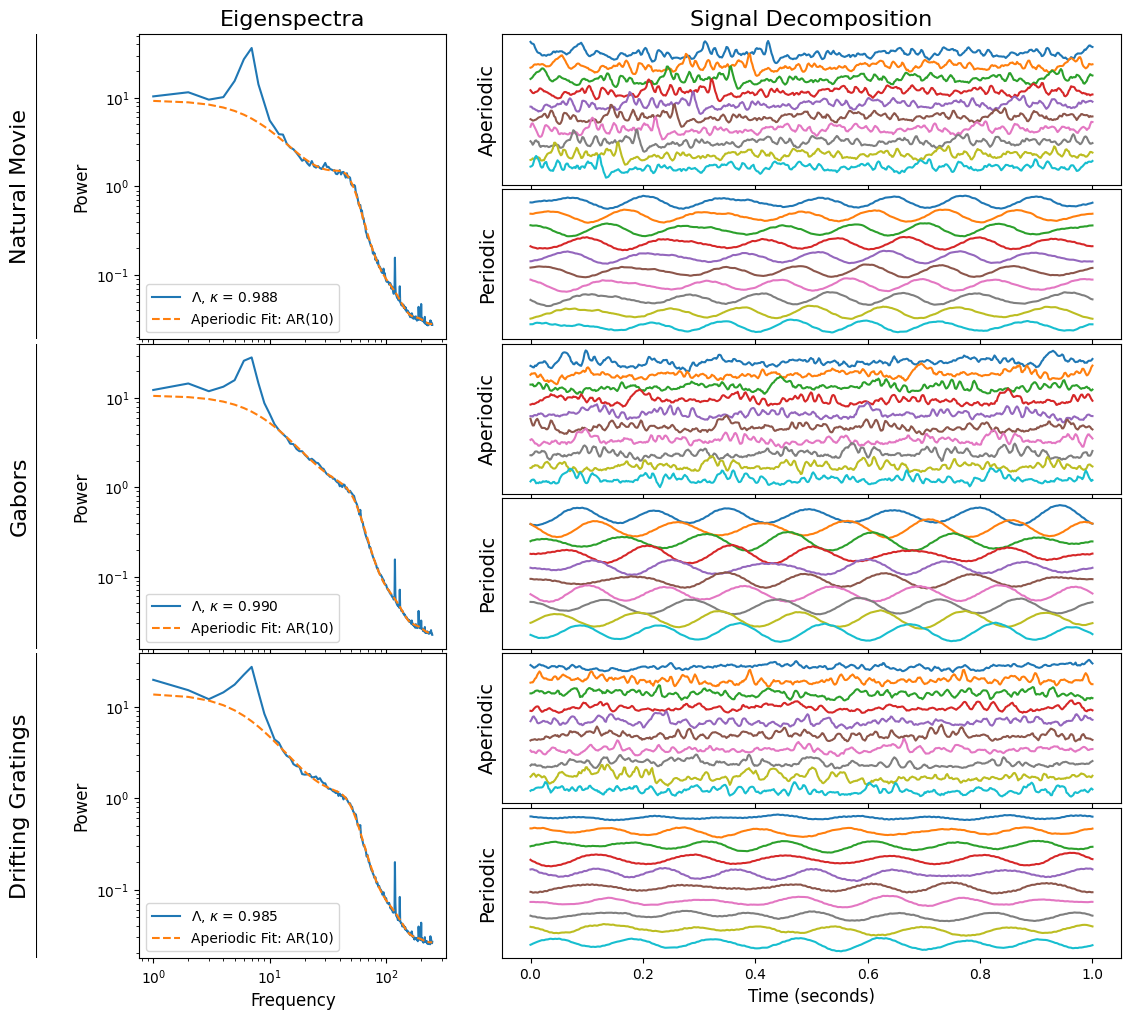

In [279]:
fig = plt.figure(constrained_layout=True, figsize=(14, 12))

# Axes
gs = fig.add_gridspec(36, 42)

axes_psd = []
axes_ylabel = []
axes_pad = []
sharex = None
for i in range(0, 36, 12):    
    if i != 0:
        sharex = axes_psd[-1]
    axes_psd.append(fig.add_subplot(gs[i:i+12, 4:16], sharex=sharex))
    axes_ylabel.append(fig.add_subplot(gs[i:i+12, :1]))

axes_sig = []
for i in range(0, 36, 6):
    axes_sig.append(fig.add_subplot(gs[i:i+6, 18:]))
    
# Plot
for i in range(len(powers)):
    axes_psd[i].loglog(freqs[1:], powers[i][1:], label=rf"$\Lambda$, $\kappa$ = {kappas[i].round(3):.3f}")
    axes_psd[i].loglog(freqs[1:], powers_fit[i][1:], ls='--', label="Aperiodic Fit: AR(10)")
    axes_psd[i].legend()

times = np.linspace(0., 1., 500)

for i in range(3):
    ii = i * 2
    
    s = 1.
    ps = 6 * s
    for j in range(10):
        axes_sig[ii].plot(times, X_re_ap[i][j]-(ps*j))
    
    ps = 2 * s
    for j in range(10):
        axes_sig[ii+1].plot(times, X[i][j]-X_re_ap[i][j]-(ps*j))

for ax in axes_ylabel:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])


axes_ylabel[0].set_ylabel("Natural Movie", size=16)
axes_ylabel[0].axvline(0, color="k")

axes_ylabel[1].set_ylabel("Gabors", size=16)
axes_ylabel[1].axvline(0, color="k")

axes_ylabel[2].set_ylabel("Drifting Gratings", size=16)
axes_ylabel[2].axvline(0, color="k")

for ax in axes_sig[::2]:
    ax.set_yticks([])
    ax.set_ylabel("Aperiodic", size=14)

for ax in axes_sig[1::2]:
    ax.set_yticks([])
    ax.set_ylabel("Periodic", size=14)

axes_psd[-1].set_xlabel("Frequency", size=12)
for ax in axes_psd:
    ax.set_ylabel("Power", size=12)

axes_sig[-1].set_xlabel("Time (seconds)", size=12)

#plt.suptitle("Eigenspectra & Signal Decomposition", size=20, y=0.92)
axes_psd[0].set_title("Eigenspectra", size=16)
axes_sig[0].set_title("Signal Decomposition", size=16)
plt.tight_layout()

plt.savefig("allen.svg")